In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [19]:
res_prefix = 'rs_empkep_fixr_results_rms_oldcurve' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [20]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [21]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e11, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt(1.08**2),   # (0.1*tb7)**2 + 1.08**2
                yerr = np.sqrt(0.49**2),  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    return fig, ax, (Tb_6_pred[4], Tb_6_err) , (Tb_7_pred[4], Tb_7_err)

### Temperature estimation (fix v)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [7]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

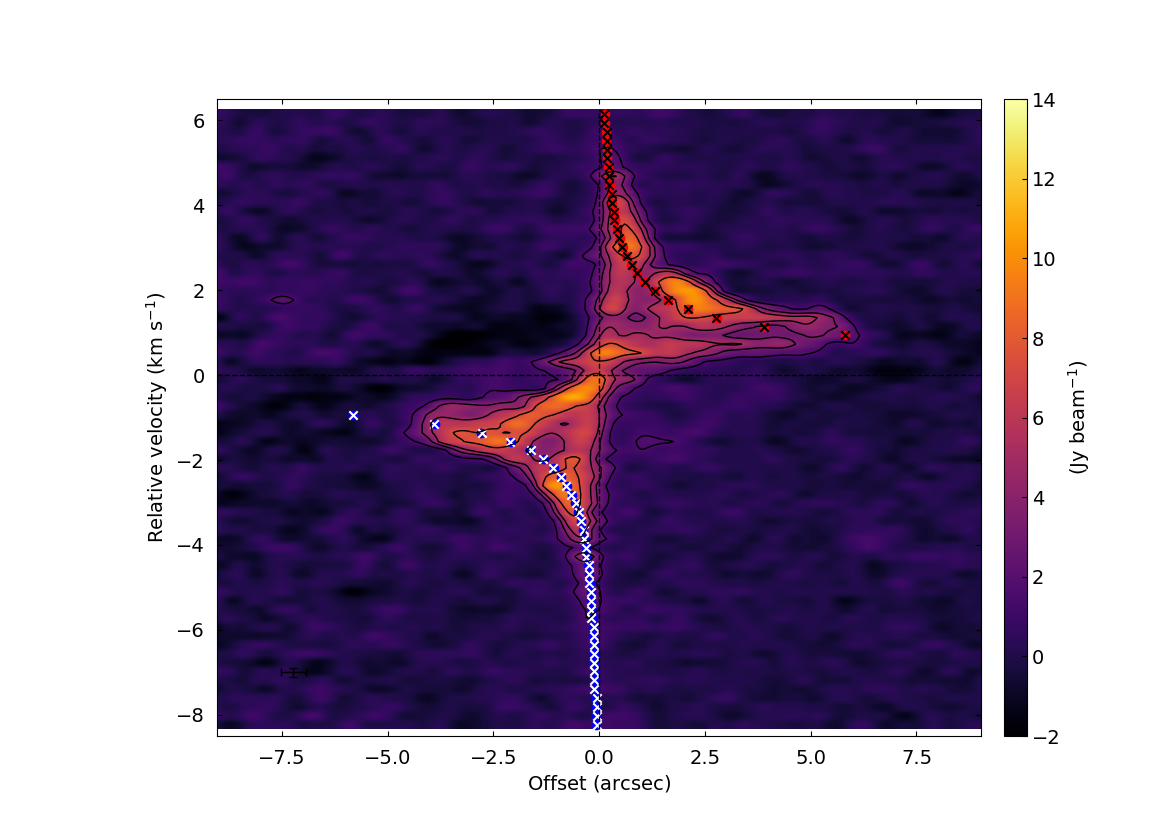

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


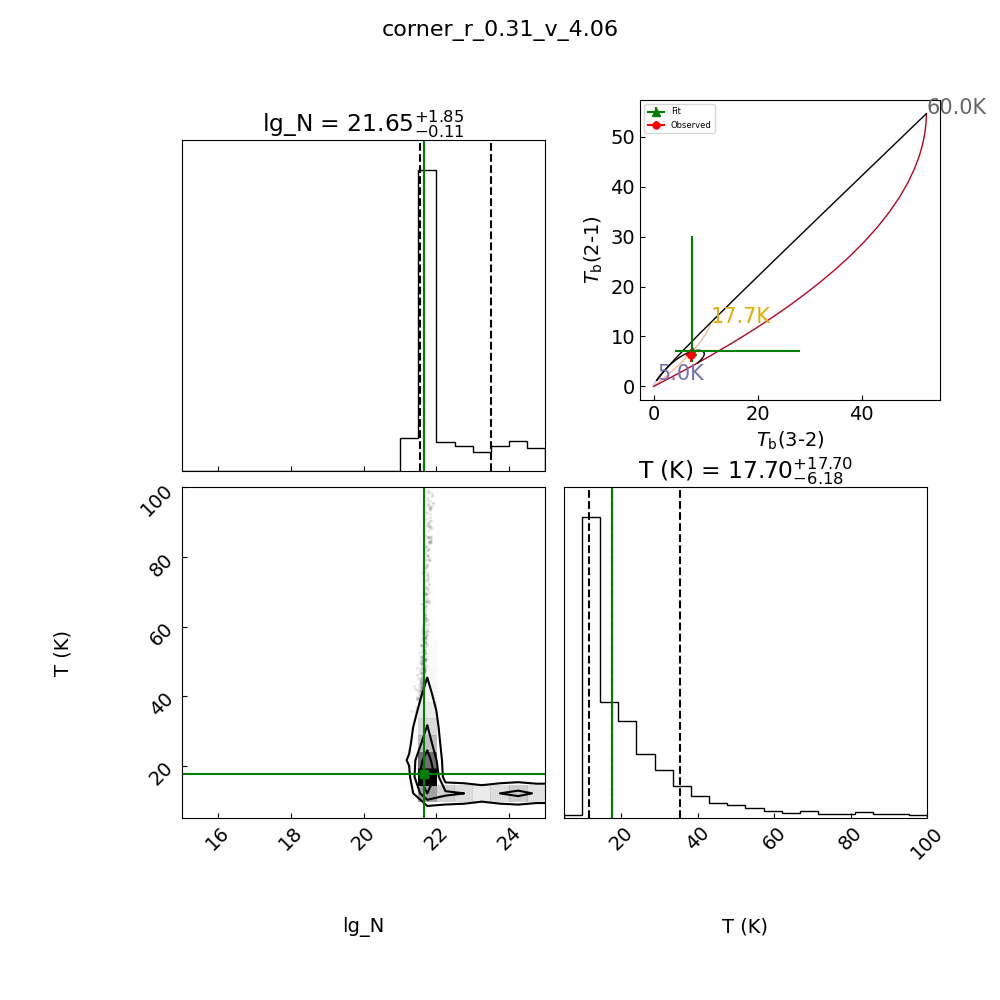

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

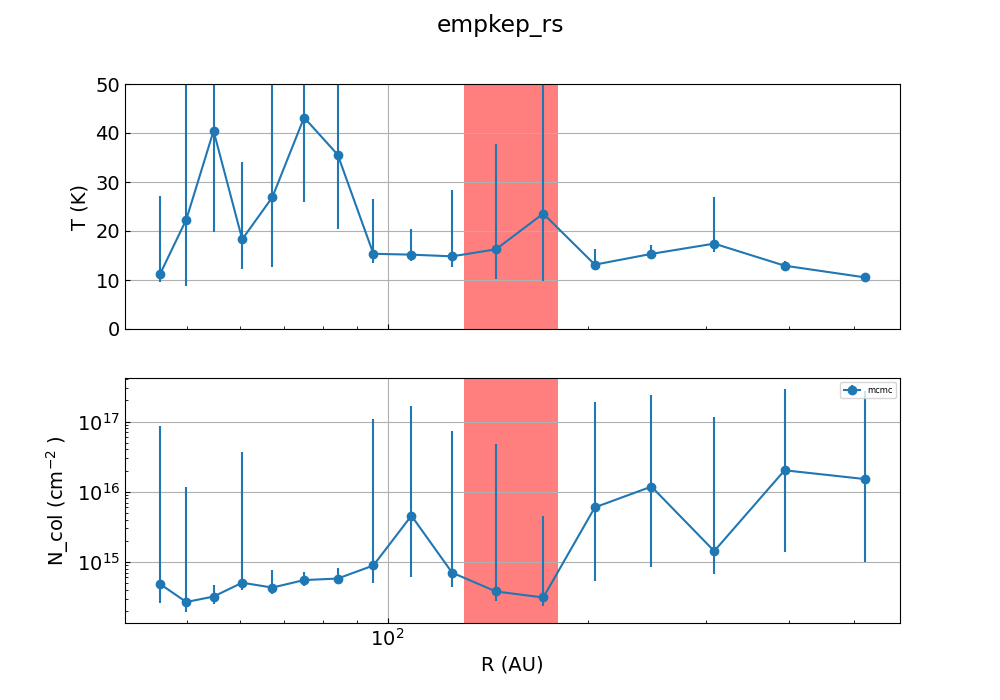

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [22]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.22) # V_sys - 7.22, 7.27 7.384
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.22)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [23]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = 3.2 #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [24]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [25]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

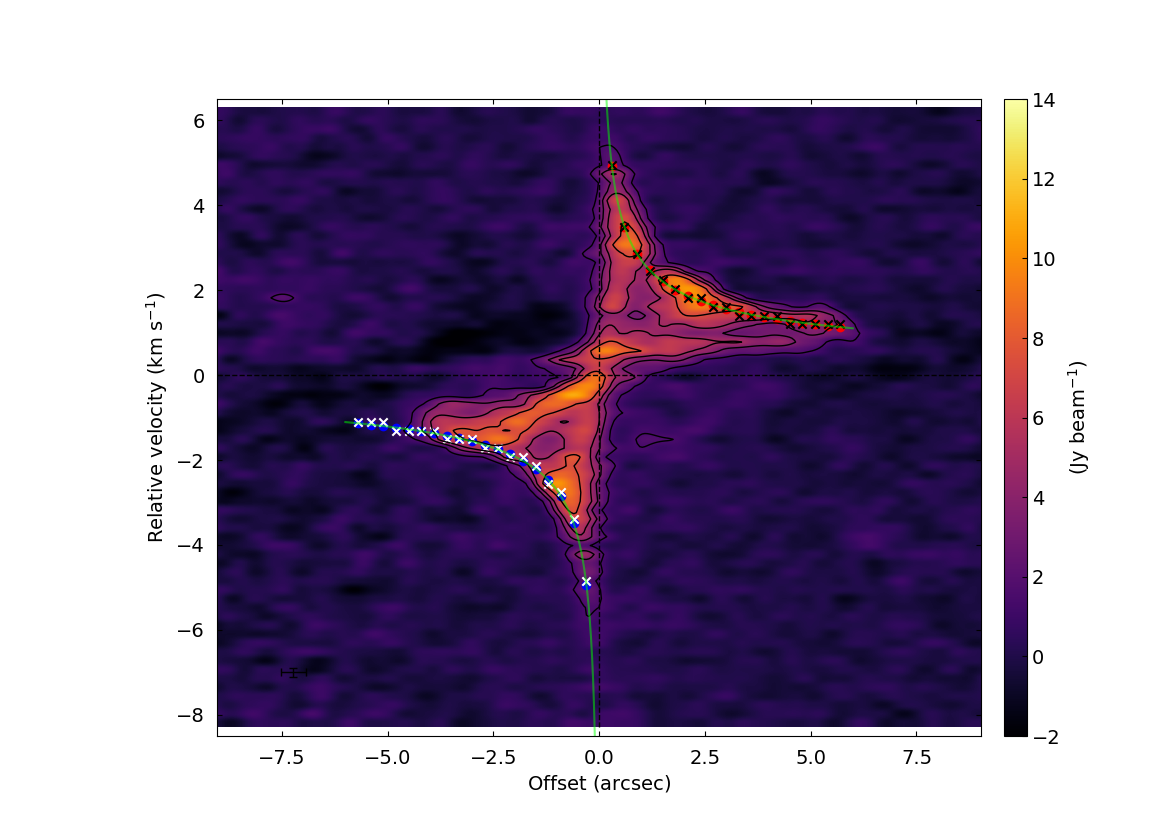

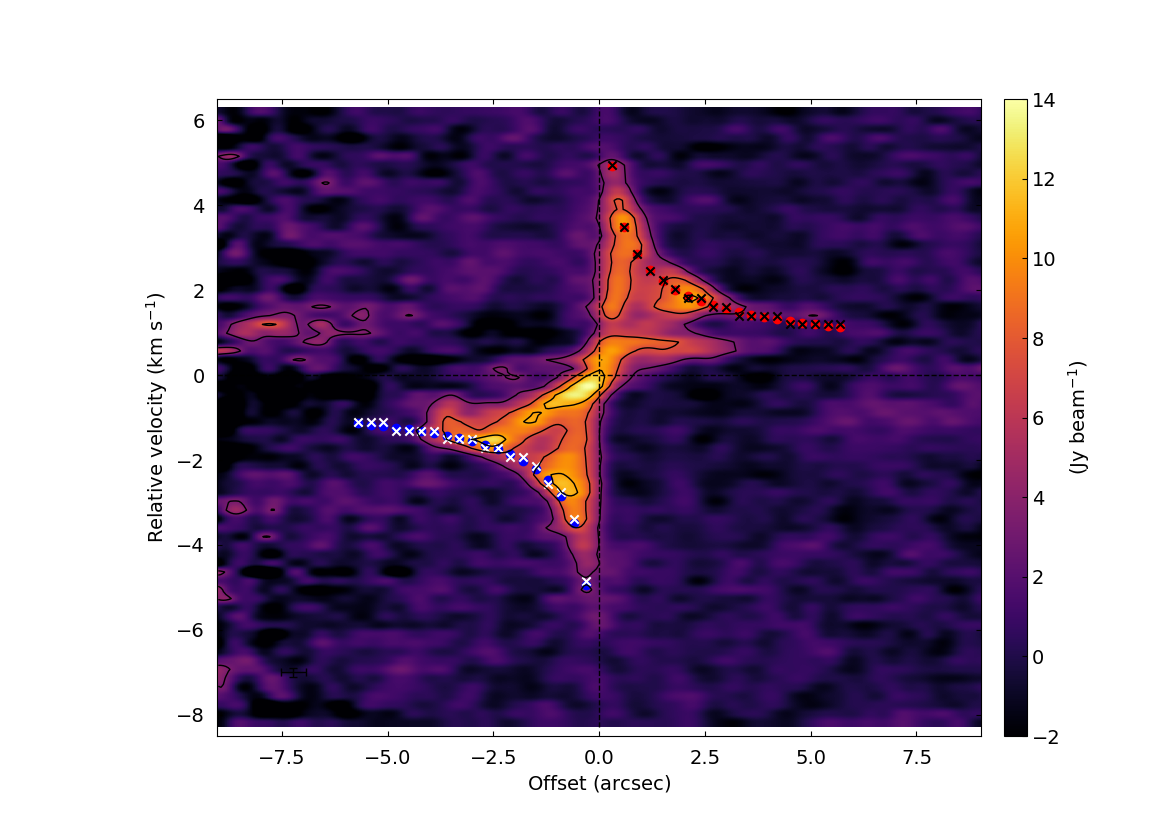

In [26]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop (fix r)

In [27]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.000e-01 arcsec, v =  4.94 Kmps , Tb7 = 4.8, Tb6 = 2.0


100%|██████████| 10000/10000 [00:53<00:00, 185.58it/s]


dtauv_dT =  7.009464117943192e-07
dtauv_dT =  2.2170880977297314e-07
Tb7_dIv_dN = 2.33e-14, Tb6_dIv_dN = 1.53e-14
Tb7_dIv_dT = 0.10, Tb6_dIv_dT = 0.06
Ncols and lgNcols up 4.76e+15, lgNc = 1.57e+01
Ncols and lgNcols med 1.58e+14, lgNc = 1.42e+01
Ncols and lgNcols dwn 1.21e+14, lgNc = 1.41e+01
del T -> + 14.42, - 37.35
del N -> + 4.61e+15, - 3.69e+13
[[3.84529892 1.48462357]]
[[2.35113709 0.90774569]]


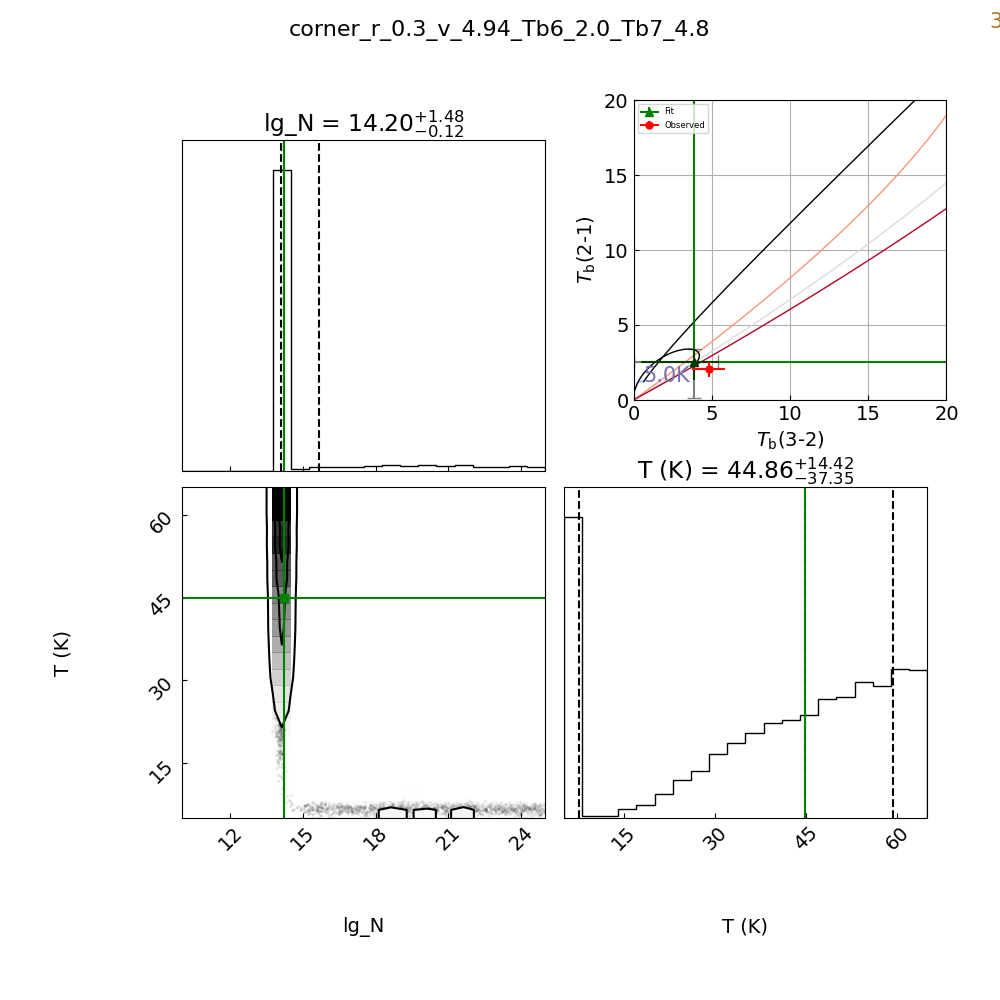

estimating for r = 6.000e-01 arcsec, v =  3.49 Kmps , Tb7 = 10.3, Tb6 = 7.6


100%|██████████| 10000/10000 [00:53<00:00, 185.21it/s]


dtauv_dT =  6.988449917462256e-06
dtauv_dT =  2.4110031560441295e-06
Tb7_dIv_dN = 1.68e-14, Tb6_dIv_dN = 1.37e-14
Tb7_dIv_dT = 0.37, Tb6_dIv_dT = 0.26
Ncols and lgNcols up 7.48e+17, lgNc = 1.79e+01
Ncols and lgNcols med 5.05e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.53e+14, lgNc = 1.47e+01
del T -> + 13.90, - 22.63
del N -> + 7.47e+17, - 5.17e+13
[[8.45580944 5.19307583]]
[[5.90383811 3.62580065]]


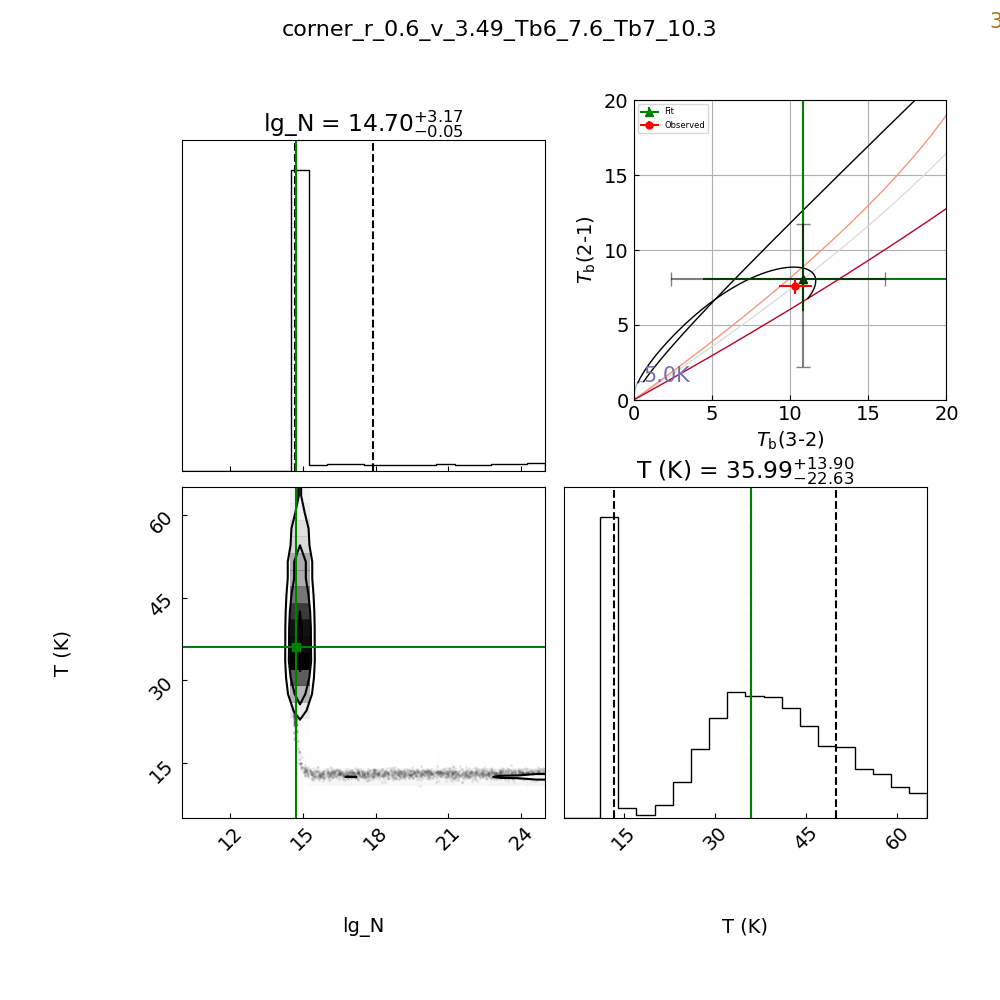

estimating for r = 9.000e-01 arcsec, v =  2.85 Kmps , Tb7 = 8.2, Tb6 = 7.4


100%|██████████| 10000/10000 [00:57<00:00, 174.37it/s]


dtauv_dT =  0.11458797028775584
dtauv_dT =  0.08588821056087433
Tb7_dIv_dN = 6.13e-109, Tb6_dIv_dN = 4.00e-126
Tb7_dIv_dT = 0.89, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.80e+22, lgNc = 2.24e+01
Ncols and lgNcols med 9.53e+16, lgNc = 1.70e+01
Ncols and lgNcols dwn 4.32e+14, lgNc = 1.46e+01
del T -> + 13.45, - 0.73
del N -> + 2.80e+22, - 9.48e+16
[[ 0.64750272 11.91472182]]
[[ 0.69248649 12.74246981]]


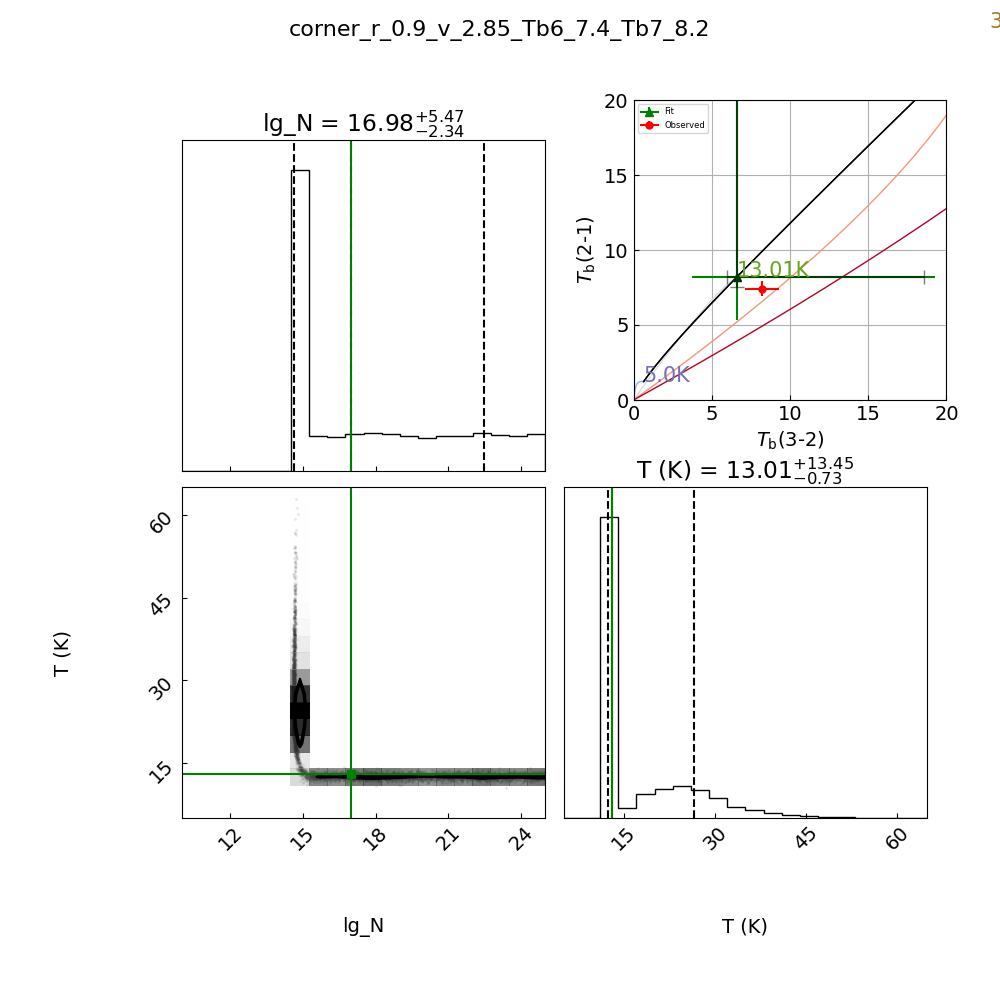

estimating for r = 1.200e+00 arcsec, v =  2.47 Kmps , Tb7 = 5.3, Tb6 = 4.5


100%|██████████| 10000/10000 [00:52<00:00, 189.22it/s]


dtauv_dT =  0.00016265477145103788
dtauv_dT =  9.46279018062276e-05
Tb7_dIv_dN = 1.04e-14, Tb6_dIv_dN = 1.21e-14
Tb7_dIv_dT = 0.45, Tb6_dIv_dT = 0.46
Ncols and lgNcols up 4.19e+21, lgNc = 2.16e+01
Ncols and lgNcols med 3.22e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 2.34e+14, lgNc = 1.44e+01
del T -> + 23.89, - 7.34
del N -> + 4.19e+21, - 8.80e+13
[[ 3.31346138 11.63305733]]
[[ 3.38233254 12.13072373]]


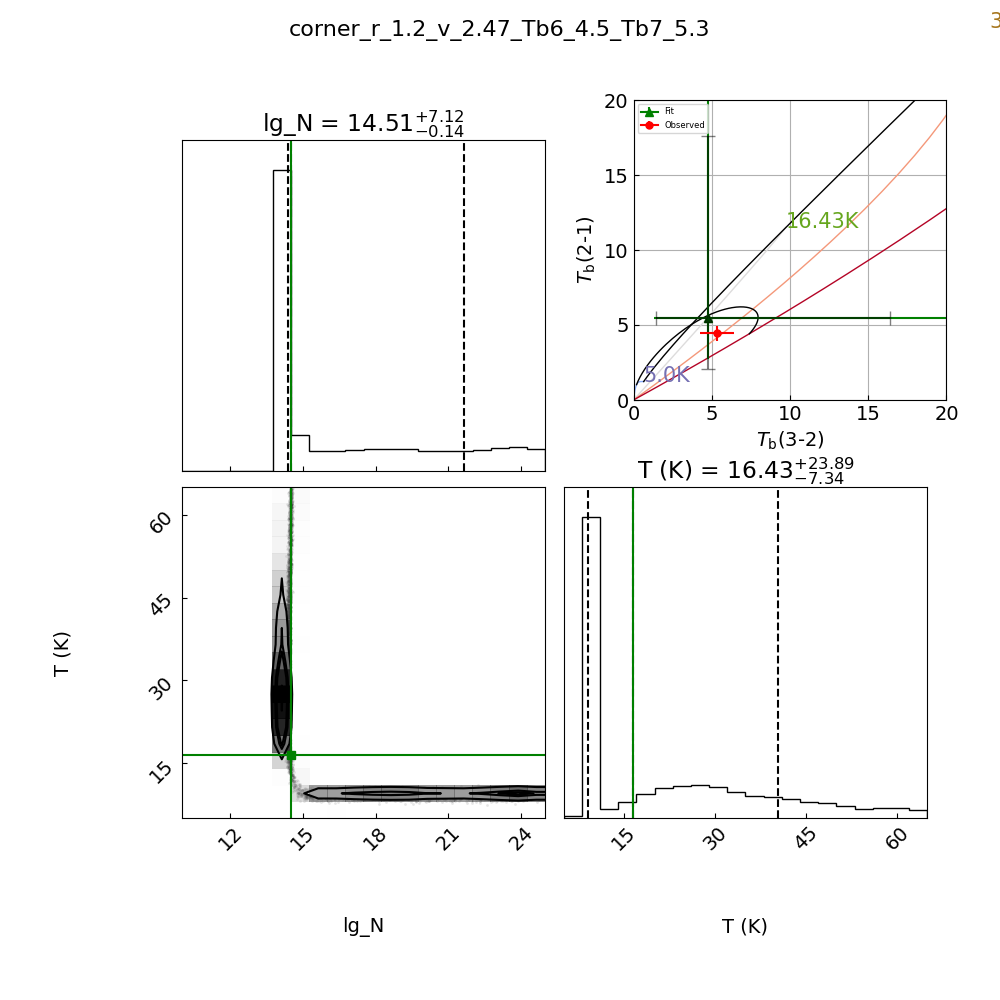

estimating for r = 1.500e+00 arcsec, v =  2.21 Kmps , Tb7 = 7.2, Tb6 = 8.2


100%|██████████| 10000/10000 [00:59<00:00, 168.82it/s]


dtauv_dT =  43.00017770132755
dtauv_dT =  31.85955751358299
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.89, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 1.94e+23, lgNc = 2.33e+01
Ncols and lgNcols med 3.69e+19, lgNc = 1.96e+01
Ncols and lgNcols dwn 7.86e+15, lgNc = 1.59e+01
del T -> + 0.57, - 0.51
del N -> + 1.94e+23, - 3.69e+19
[[0.4498159  0.50763431]]
[[0.48046409 0.54222195]]


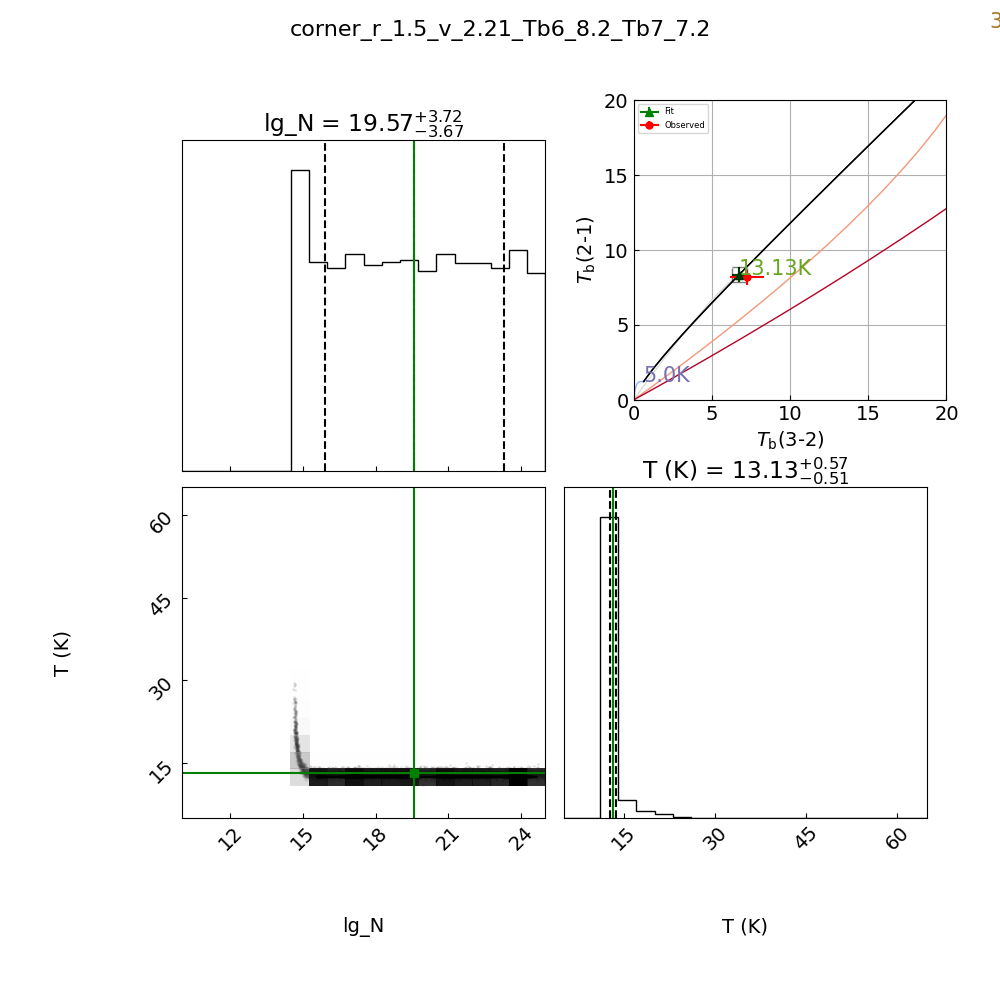

estimating for r = 1.800e+00 arcsec, v =  2.02 Kmps , Tb7 = 9.1, Tb6 = 9.8


100%|██████████| 10000/10000 [01:00<00:00, 166.53it/s]


dtauv_dT =  18.52806392661828
dtauv_dT =  11.901921219531868
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.91, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 1.59e+23, lgNc = 2.32e+01
Ncols and lgNcols med 2.51e+19, lgNc = 1.94e+01
Ncols and lgNcols dwn 4.68e+15, lgNc = 1.57e+01
del T -> + 0.64, - 0.50
del N -> + 1.59e+23, - 2.51e+19
[[0.45571273 0.58087033]]
[[0.47974956 0.61150867]]


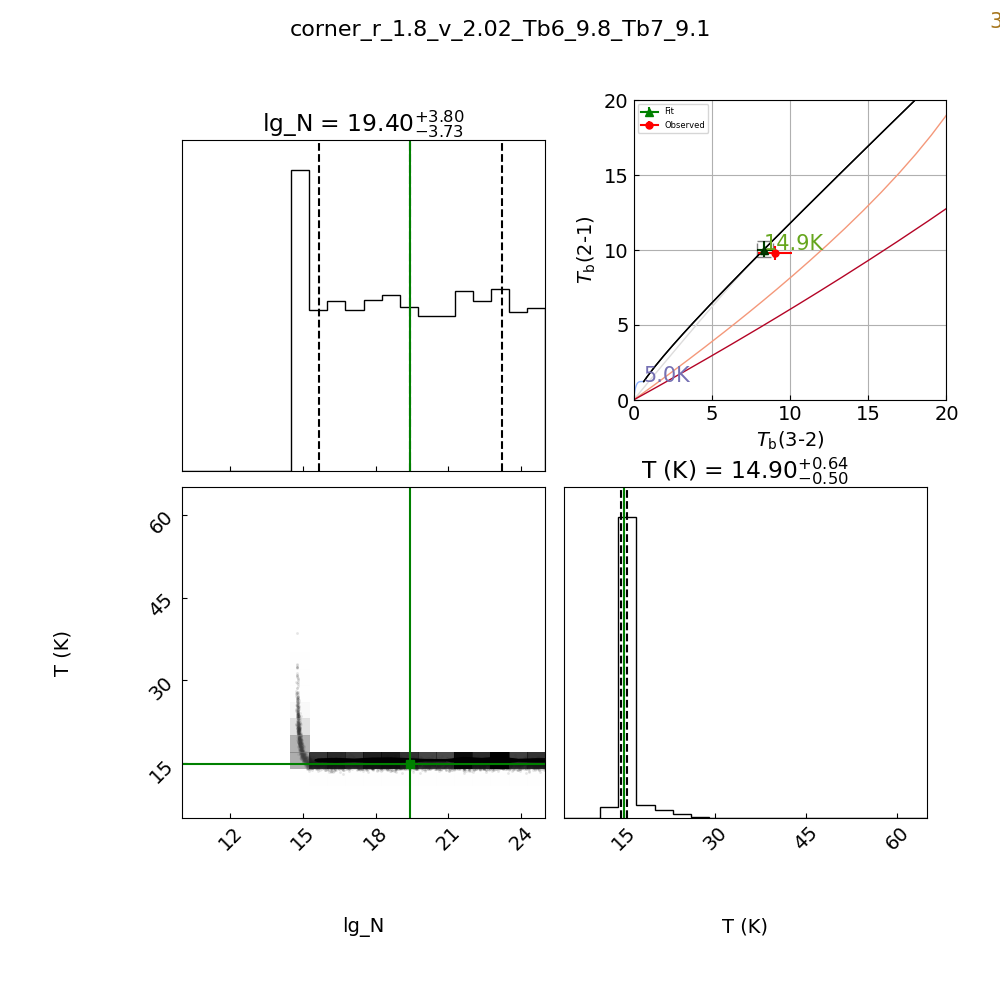

estimating for r = 2.100e+00 arcsec, v =  1.87 Kmps , Tb7 = 11.2, Tb6 = 9.8


100%|██████████| 10000/10000 [01:08<00:00, 145.46it/s]


dtauv_dT =  6.759335435090753e-05
dtauv_dT =  2.916765949691649e-05
Tb7_dIv_dN = 9.31e-15, Tb6_dIv_dN = 1.01e-14
Tb7_dIv_dT = 0.62, Tb6_dIv_dT = 0.53
Ncols and lgNcols up 1.29e+20, lgNc = 2.01e+01
Ncols and lgNcols med 6.62e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.94e+14, lgNc = 1.48e+01
del T -> + 8.07, - 8.69
del N -> + 1.29e+20, - 6.82e+13
[[5.35653076 4.97687263]]
[[4.6292425  4.30186254]]


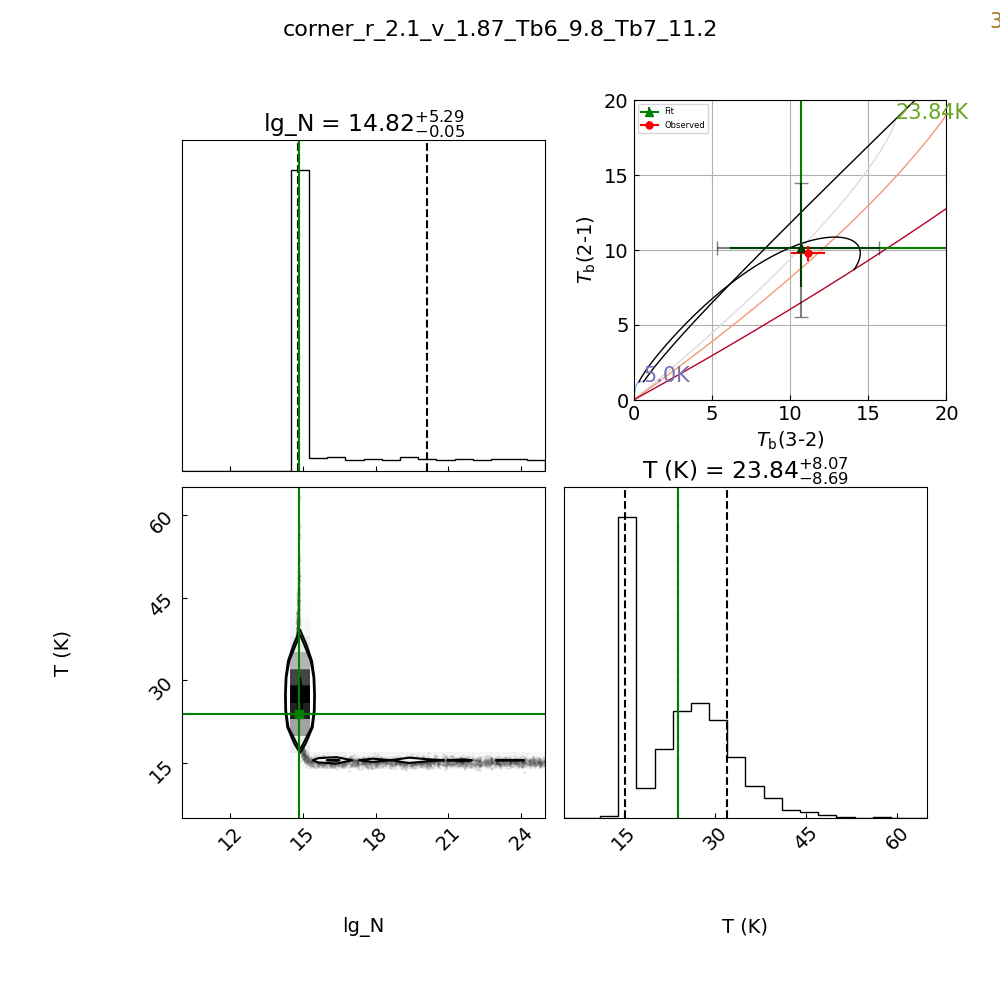

estimating for r = 2.400e+00 arcsec, v =  1.75 Kmps , Tb7 = 10.4, Tb6 = 9.8


100%|██████████| 10000/10000 [01:01<00:00, 162.18it/s]


dtauv_dT =  0.21209683439894986
dtauv_dT =  0.13193635995479258
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.92, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 3.71e+22, lgNc = 2.26e+01
Ncols and lgNcols med 3.23e+17, lgNc = 1.75e+01
Ncols and lgNcols dwn 6.31e+14, lgNc = 1.48e+01
del T -> + 9.01, - 0.66
del N -> + 3.71e+22, - 3.22e+17
[[0.60375097 8.25371915]]
[[0.63367377 8.66278574]]


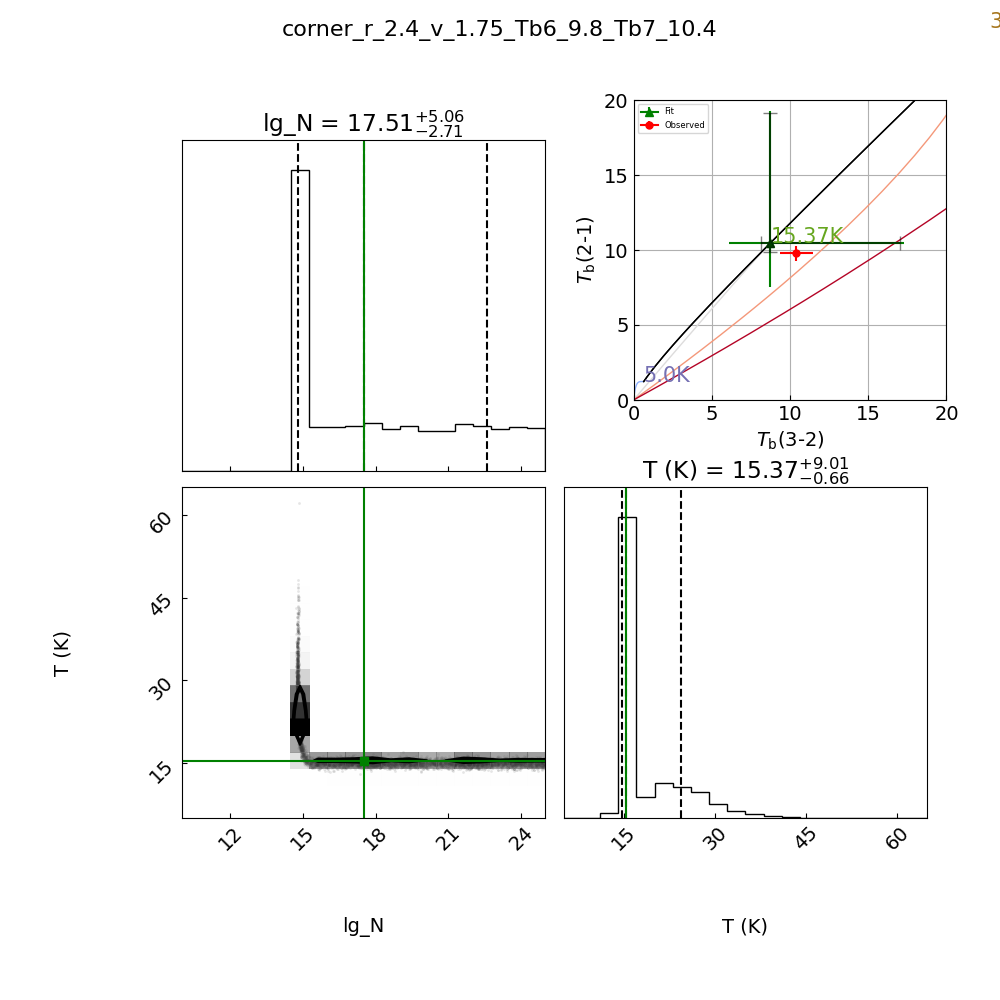

estimating for r = 2.700e+00 arcsec, v =  1.65 Kmps , Tb7 = 6.4, Tb6 = 8.8


100%|██████████| 10000/10000 [01:03<00:00, 157.81it/s]


dtauv_dT =  47.16152942887369
dtauv_dT =  33.7771077903339
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.89, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 1.86e+23, lgNc = 2.33e+01
Ncols and lgNcols med 4.48e+19, lgNc = 1.97e+01
Ncols and lgNcols dwn 1.71e+16, lgNc = 1.62e+01
del T -> + 0.52, - 0.49
del N -> + 1.86e+23, - 4.48e+19
[[0.4348471  0.46818986]]
[[0.46280368 0.49829007]]


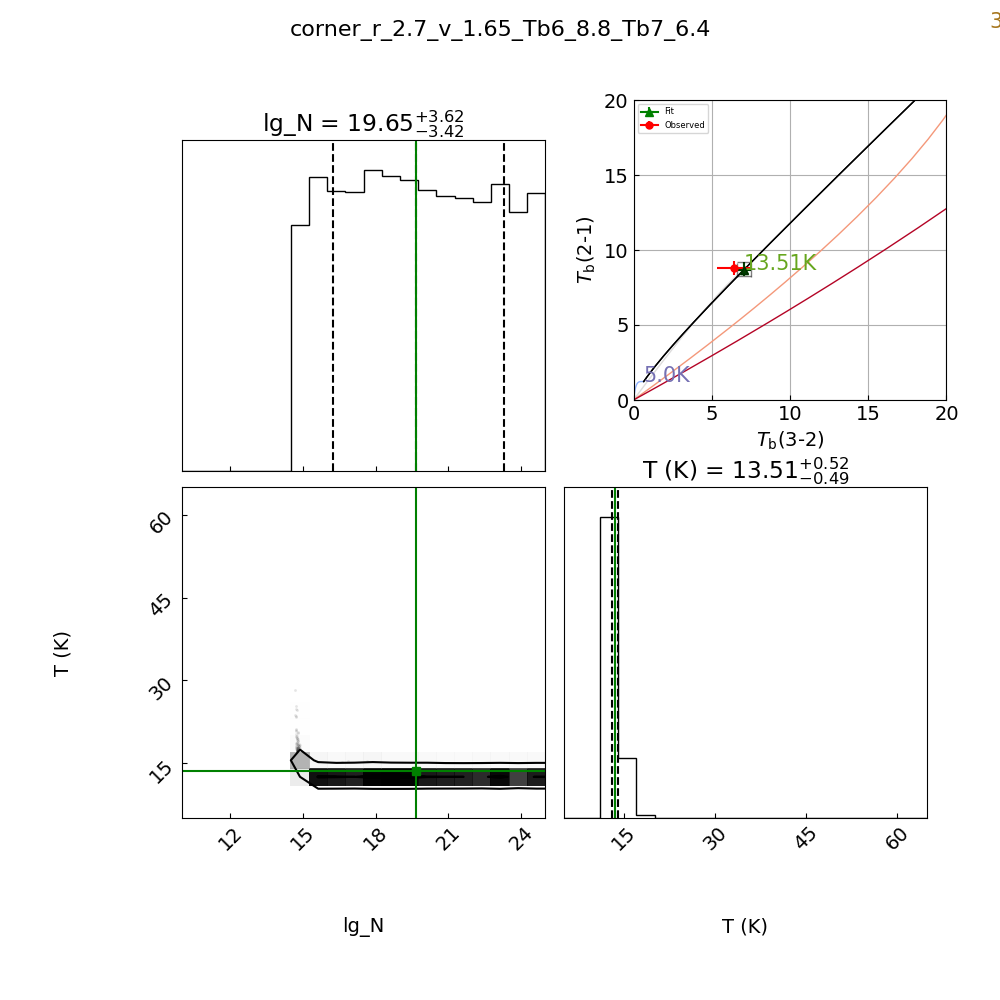

estimating for r = 3.000e+00 arcsec, v =  1.56 Kmps , Tb7 = 5.2, Tb6 = 8.2


100%|██████████| 10000/10000 [01:04<00:00, 156.00it/s]


dtauv_dT =  109.3017968837325
dtauv_dT =  83.90082607126499
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.88, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.21e+23, lgNc = 2.33e+01
Ncols and lgNcols med 8.51e+19, lgNc = 1.99e+01
Ncols and lgNcols dwn 1.84e+16, lgNc = 1.63e+01
del T -> + 0.52, - 0.50
del N -> + 2.21e+23, - 8.50e+19
[[0.43939135 0.46106162]]
[[0.47114593 0.4943823 ]]


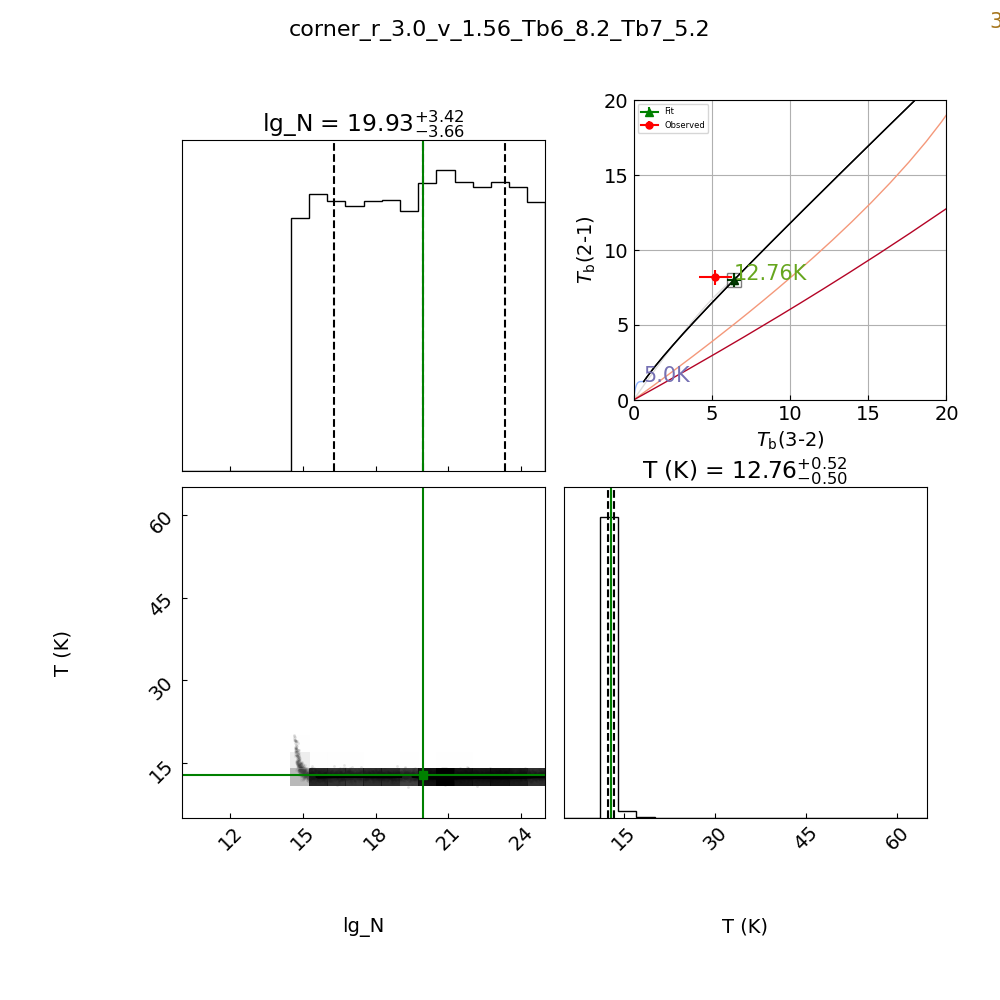

estimating for r = 3.300e+00 arcsec, v =  1.49 Kmps , Tb7 = 2.9, Tb6 = 6.5


100%|██████████| 10000/10000 [01:05<00:00, 152.52it/s]


dtauv_dT =  66.29291716520352
dtauv_dT =  62.89163805496812
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.76e+23, lgNc = 2.32e+01
Ncols and lgNcols med 3.13e+19, lgNc = 1.95e+01
Ncols and lgNcols dwn 5.51e+15, lgNc = 1.57e+01
del T -> + 0.59, - 0.51
del N -> + 1.76e+23, - 3.13e+19
[[0.4318559  0.49788535]]
[[0.47491756 0.54753102]]


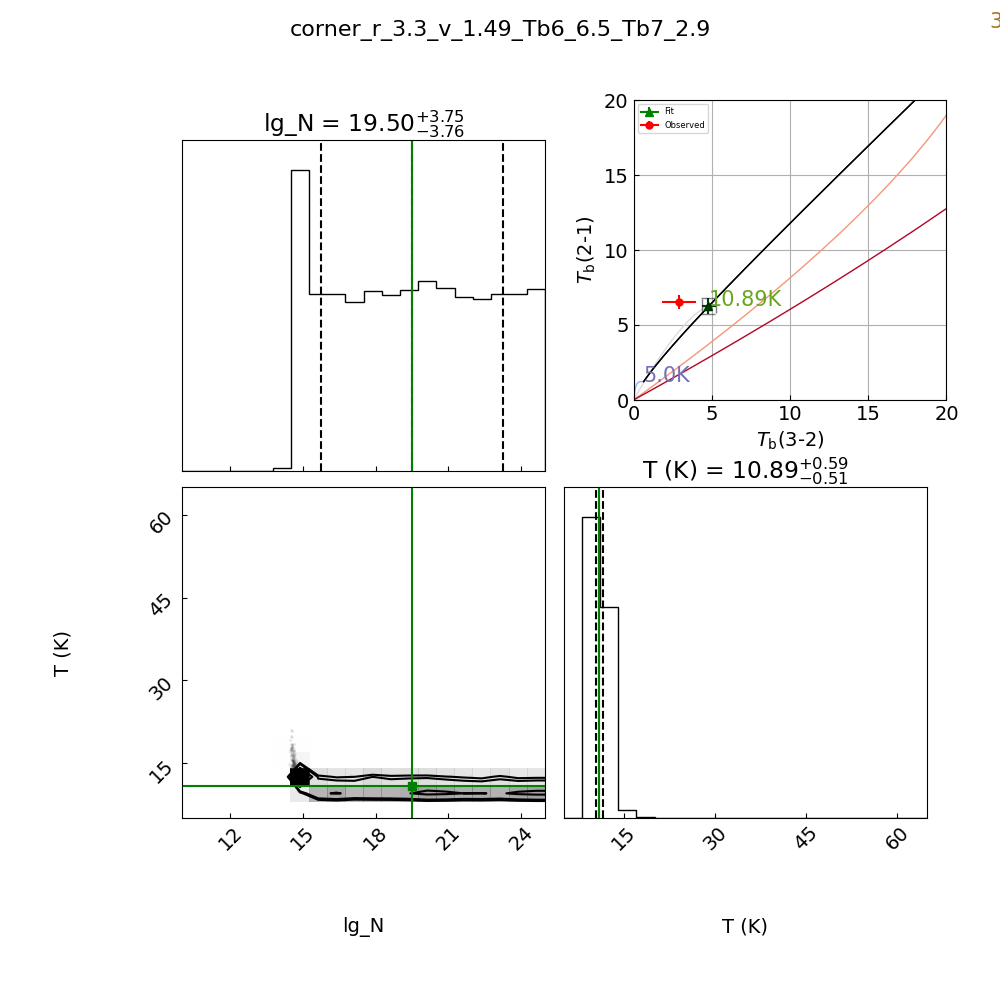

estimating for r = 3.600e+00 arcsec, v =  1.43 Kmps , Tb7 = 2.9, Tb6 = 6.6


100%|██████████| 10000/10000 [01:02<00:00, 159.41it/s]


dtauv_dT =  39.09730229204654
dtauv_dT =  36.866464115225796
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.54e+23, lgNc = 2.32e+01
Ncols and lgNcols med 1.87e+19, lgNc = 1.93e+01
Ncols and lgNcols dwn 3.24e+15, lgNc = 1.55e+01
del T -> + 0.62, - 0.52
del N -> + 1.54e+23, - 1.87e+19
[[0.43474363 0.52248496]]
[[0.4777223  0.57413771]]


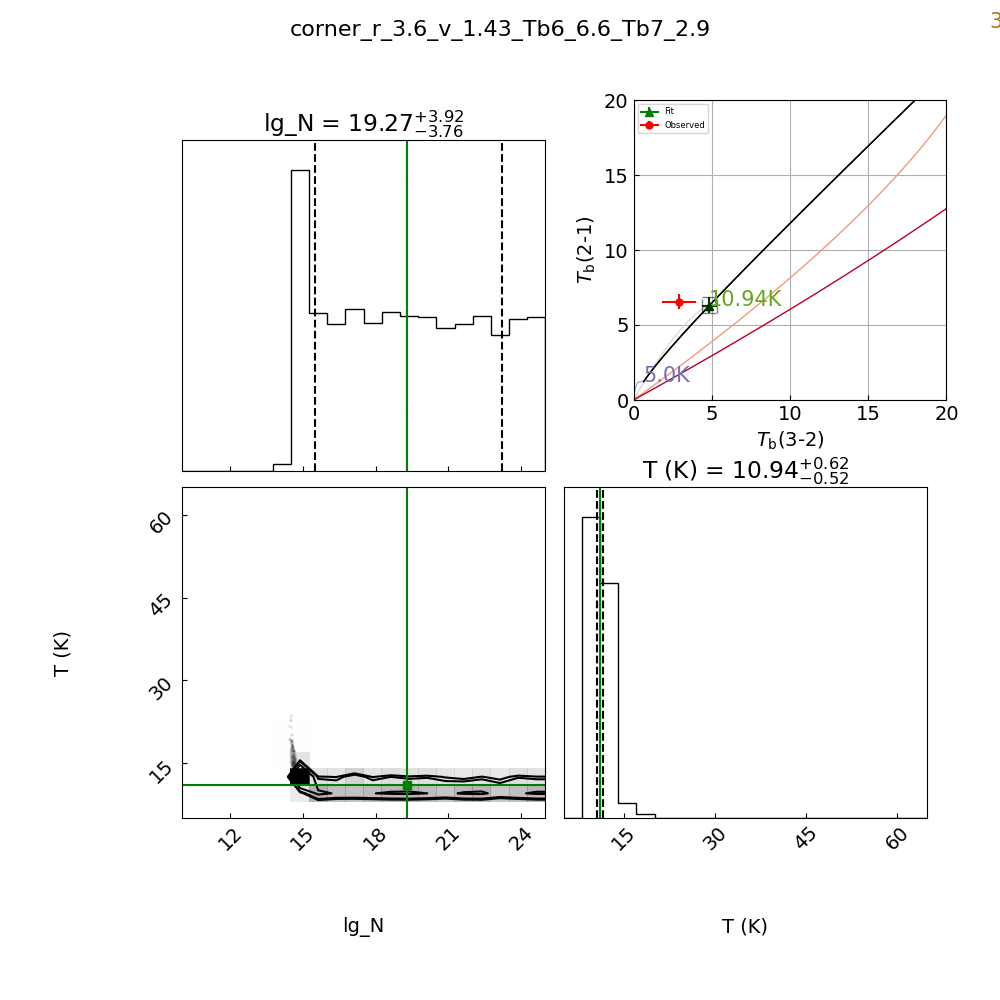

estimating for r = 3.900e+00 arcsec, v =  1.37 Kmps , Tb7 = 3.0, Tb6 = 6.3


100%|██████████| 10000/10000 [01:03<00:00, 156.48it/s]


dtauv_dT =  49.09363756512414
dtauv_dT =  47.636161343039085
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 1.62e+23, lgNc = 2.32e+01
Ncols and lgNcols med 2.22e+19, lgNc = 1.93e+01
Ncols and lgNcols dwn 4.20e+15, lgNc = 1.56e+01
del T -> + 0.57, - 0.52
del N -> + 1.62e+23, - 2.22e+19
[[0.4387771  0.47749996]]
[[0.48393107 0.52663884]]


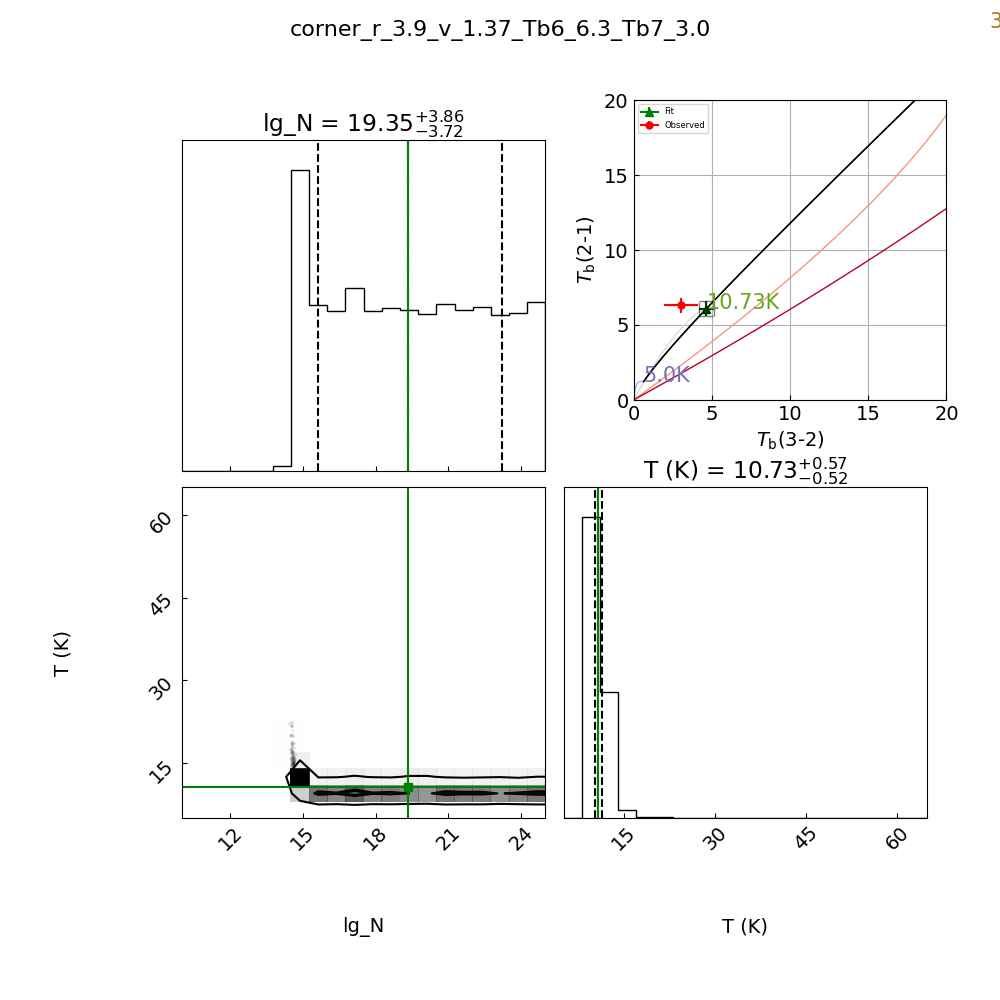

estimating for r = 4.200e+00 arcsec, v =  1.32 Kmps , Tb7 = 2.6, Tb6 = 6.0


100%|██████████| 10000/10000 [01:09<00:00, 144.43it/s]


dtauv_dT =  51.82316013562866
dtauv_dT =  53.21417783191119
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.83, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 1.52e+23, lgNc = 2.32e+01
Ncols and lgNcols med 2.11e+19, lgNc = 1.93e+01
Ncols and lgNcols dwn 3.20e+15, lgNc = 1.55e+01
del T -> + 0.60, - 0.53
del N -> + 1.52e+23, - 2.11e+19
[[0.43797908 0.49888699]]
[[0.48667256 0.55435207]]


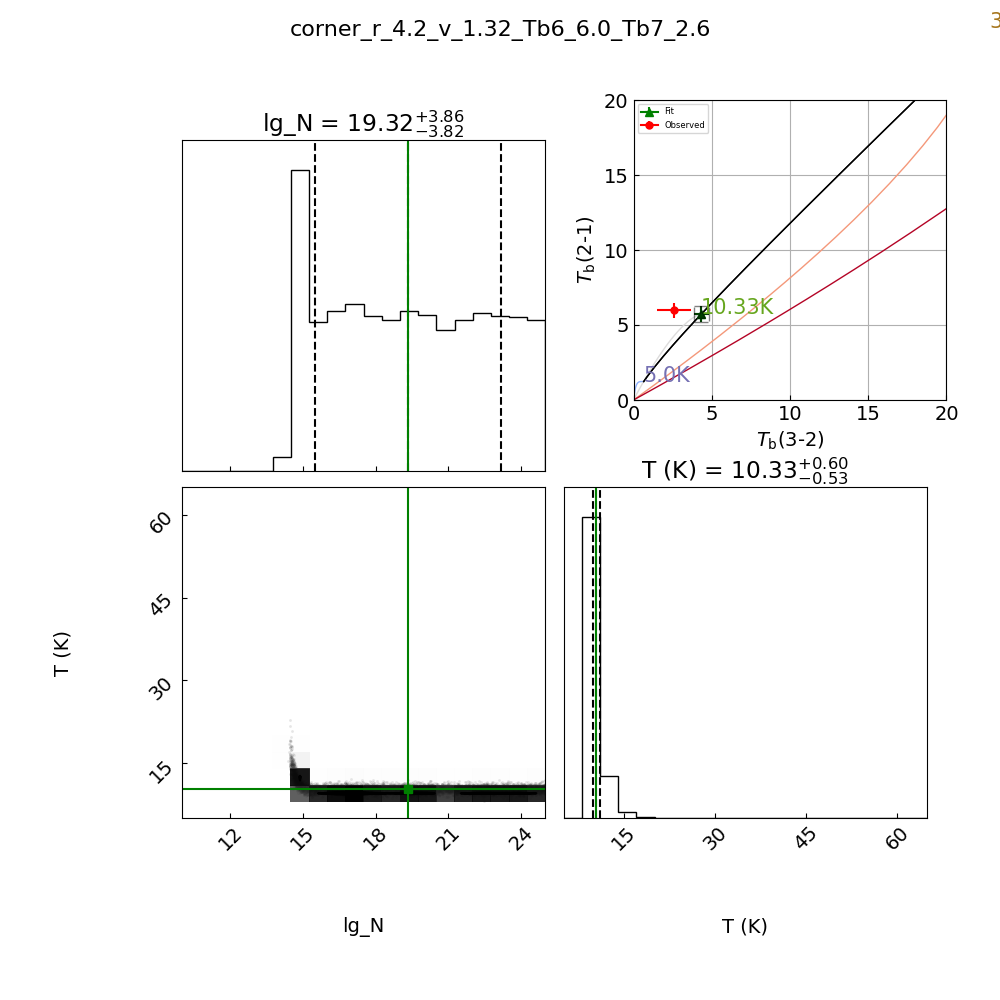

estimating for r = 4.500e+00 arcsec, v =  1.27 Kmps , Tb7 = 0.2, Tb6 = 3.7


100%|██████████| 10000/10000 [01:05<00:00, 153.15it/s]


dtauv_dT =  20.481714489265887
dtauv_dT =  34.566485196129875
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.72, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 1.03e+23, lgNc = 2.30e+01
Ncols and lgNcols med 4.42e+18, lgNc = 1.86e+01
Ncols and lgNcols dwn 5.00e+14, lgNc = 1.47e+01
del T -> + 0.89, - 0.60
del N -> + 1.03e+23, - 4.42e+18
[[0.43079064 0.63618144]]
[[0.51647247 0.76271435]]


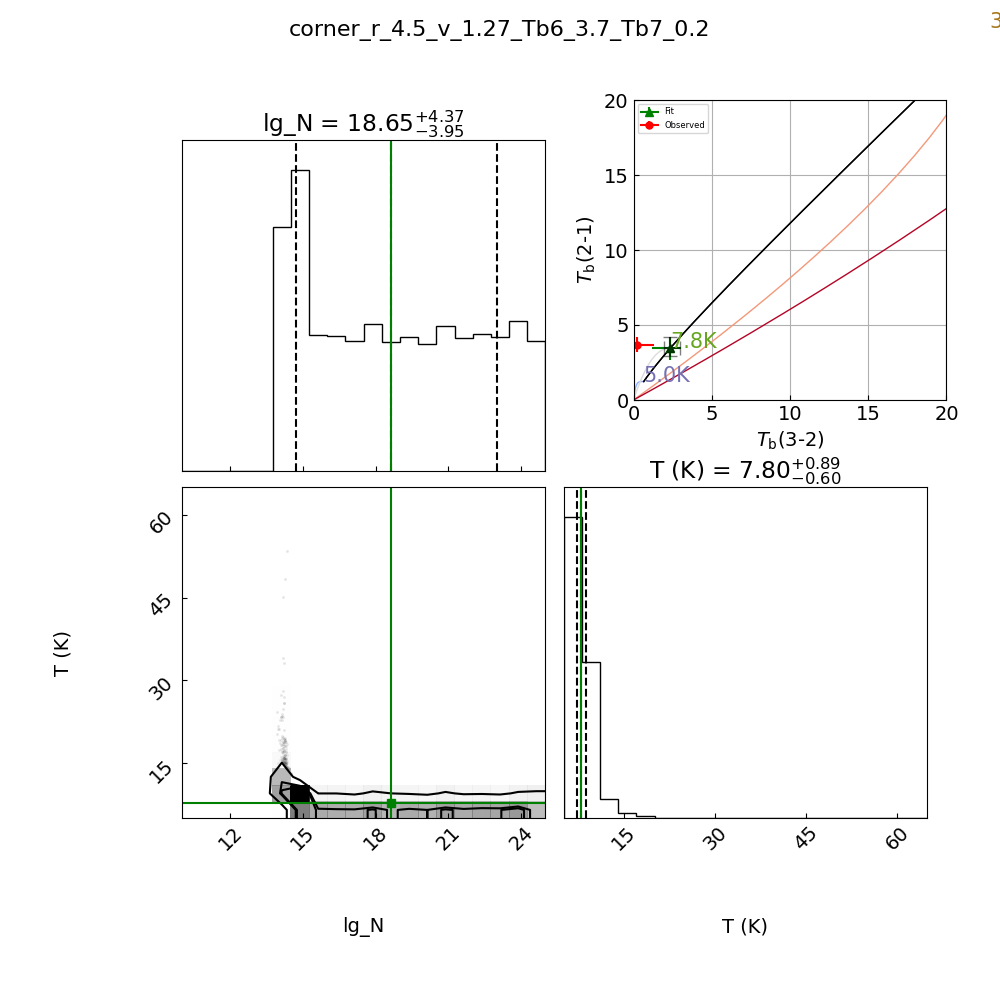

estimating for r = 4.800e+00 arcsec, v =  1.23 Kmps , Tb7 = 1.0, Tb6 = 4.5


100%|██████████| 10000/10000 [01:18<00:00, 128.13it/s]


dtauv_dT =  34.890644379173835
dtauv_dT =  47.74840914359214
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.89
Ncols and lgNcols up 1.37e+23, lgNc = 2.31e+01
Ncols and lgNcols med 9.29e+18, lgNc = 1.90e+01
Ncols and lgNcols dwn 1.16e+15, lgNc = 1.51e+01
del T -> + 0.70, - 0.57
del N -> + 1.37e+23, - 9.29e+18
[[0.4370163  0.53831694]]
[[0.50628036 0.62363644]]


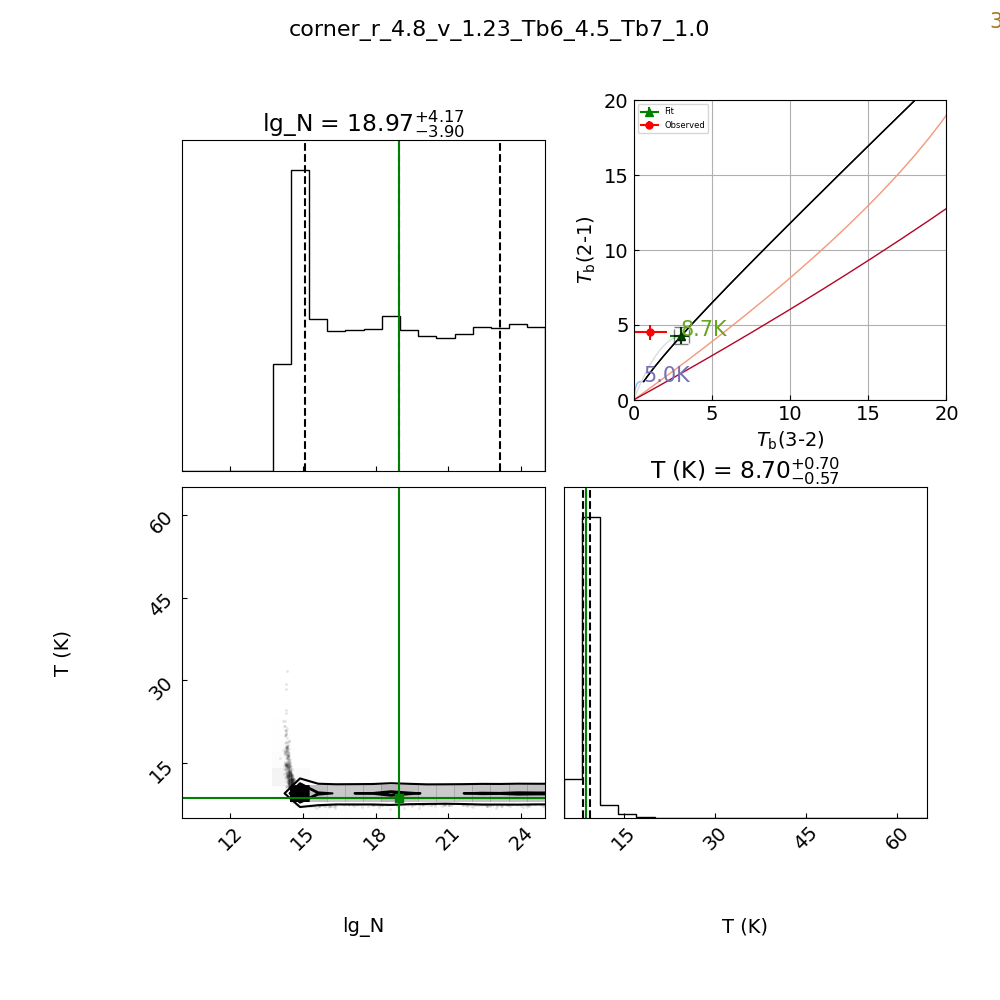

estimating for r = 5.100e+00 arcsec, v =  1.20 Kmps , Tb7 = 1.2, Tb6 = 4.3


100%|██████████| 10000/10000 [01:03<00:00, 157.27it/s]


dtauv_dT =  53.76989891890429
dtauv_dT =  76.33932666081589
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.88
Ncols and lgNcols up 1.37e+23, lgNc = 2.31e+01
Ncols and lgNcols med 1.37e+19, lgNc = 1.91e+01
Ncols and lgNcols dwn 1.14e+15, lgNc = 1.51e+01
del T -> + 0.70, - 0.55
del N -> + 1.37e+23, - 1.37e+19
[[0.41519226 0.52887044]]
[[0.48378596 0.61624485]]


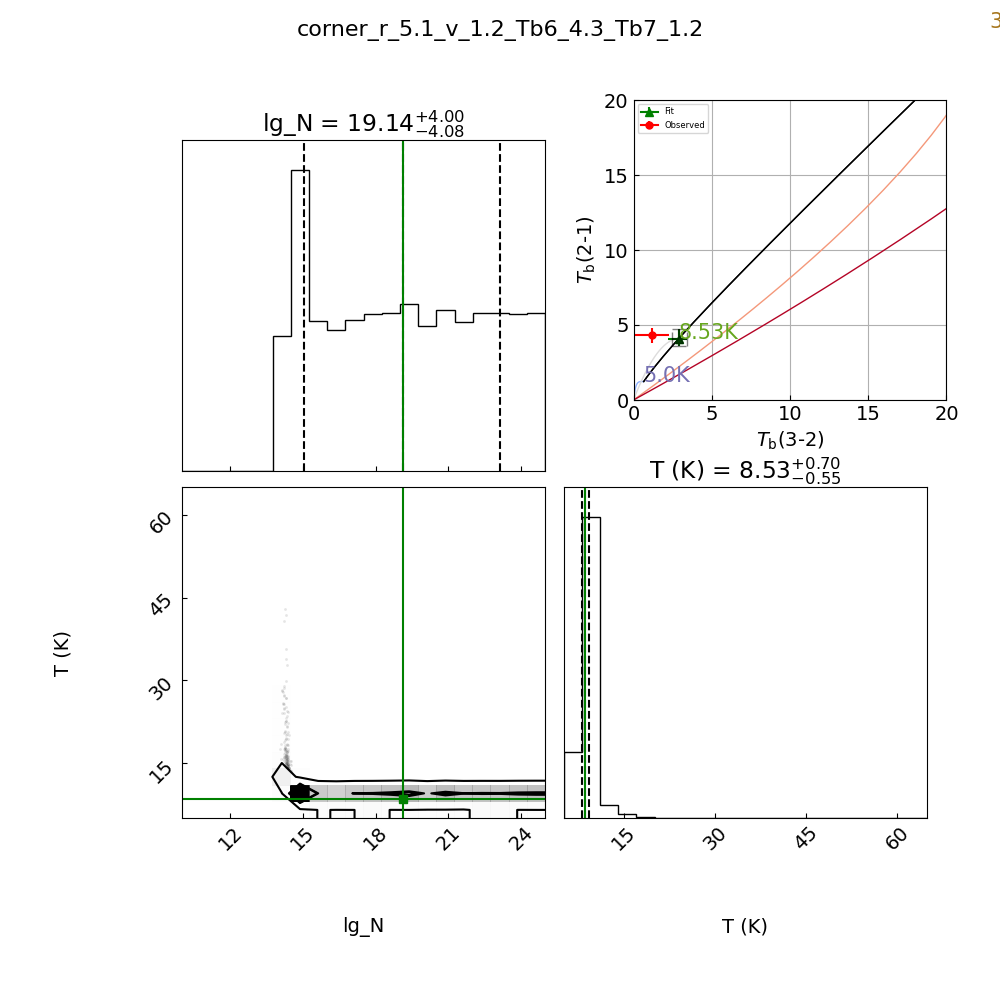

estimating for r = 5.400e+00 arcsec, v =  1.16 Kmps , Tb7 = 0.5, Tb6 = 3.7


100%|██████████| 10000/10000 [01:03<00:00, 157.16it/s]


dtauv_dT =  17.520236531876165
dtauv_dT =  29.641209717916073
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.72, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 9.92e+22, lgNc = 2.30e+01
Ncols and lgNcols med 3.77e+18, lgNc = 1.86e+01
Ncols and lgNcols dwn 5.48e+14, lgNc = 1.47e+01
del T -> + 0.86, - 0.60
del N -> + 9.92e+22, - 3.77e+18
[[0.42924163 0.6163337 ]]
[[0.51483167 0.73922958]]


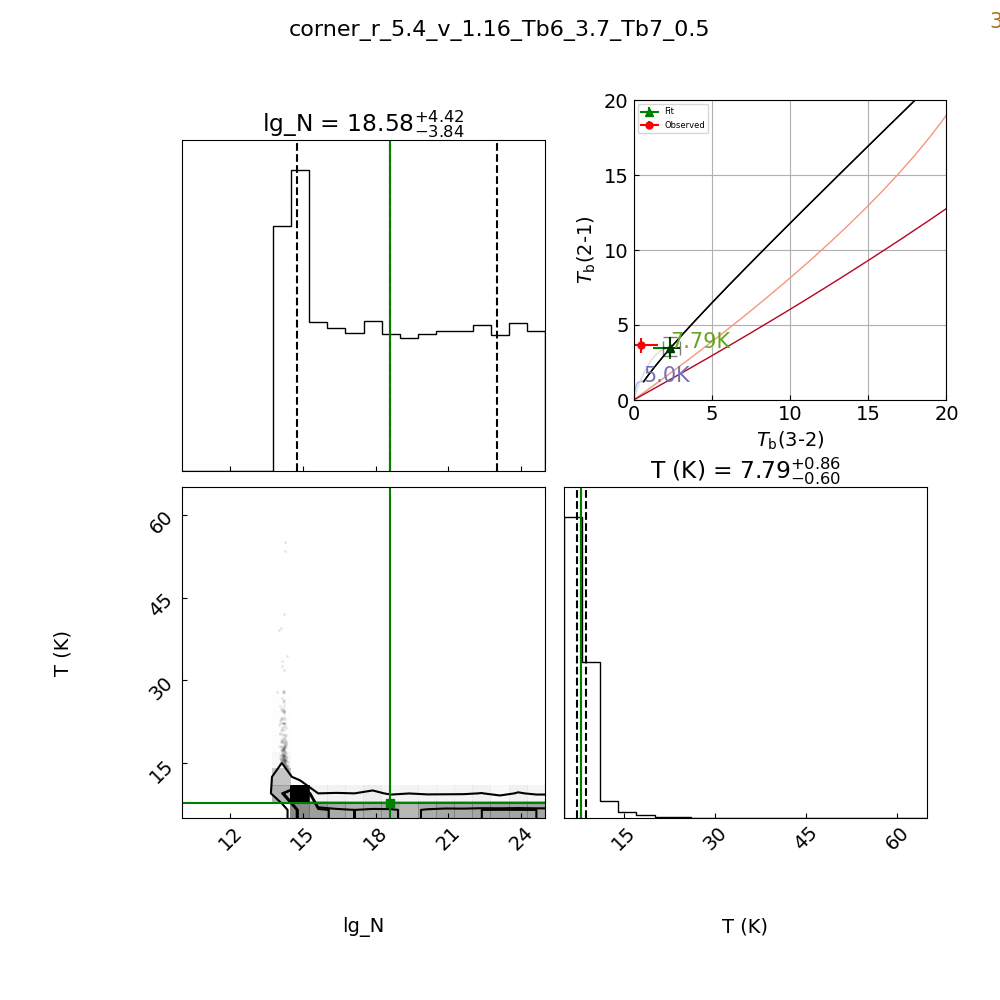

estimating for r = 5.700e+00 arcsec, v =  1.13 Kmps , Tb7 = 1.2, Tb6 = 3.3


100%|██████████| 10000/10000 [01:05<00:00, 151.63it/s]


dtauv_dT =  27.129537041387906
dtauv_dT =  49.25309316340452
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.70, Tb6_dIv_dT = 0.85
Ncols and lgNcols up 1.27e+23, lgNc = 2.31e+01
Ncols and lgNcols med 5.53e+18, lgNc = 1.87e+01
Ncols and lgNcols dwn 4.37e+14, lgNc = 1.46e+01
del T -> + 0.98, - 0.60
del N -> + 1.27e+23, - 5.53e+18
[[0.42076242 0.68995496]]
[[0.51087824 0.83772447]]


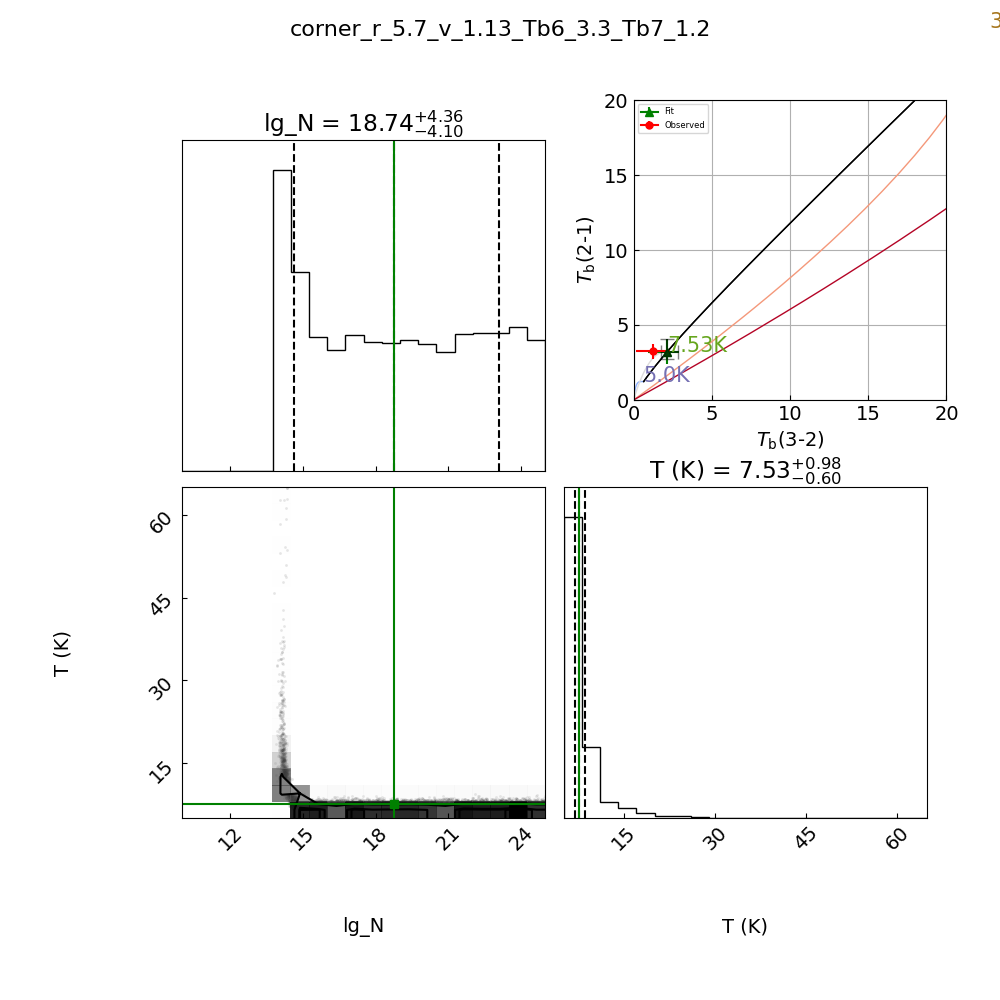

In [28]:
op_dir_label = "rs_empkep_fixr_results_rms_oldcurve"

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

plot_corner = True

np.random.seed(41)

# N_conv_fraction = 1.e-7
lg_n_bounds = [10.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_redshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt( 1.08**2 ), #(0.1*Tb7)**2 + 1.08**2
                                                    s2=np.sqrt( 0.49**2 ),  # (0.1*Tb6)**2 + 0.49**2
                                                    estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 0.1, args= None,
                                                    nwalkers = 50, n_steps = 10000, burn_in = 2000, thin_by = 50, 
                                                    return_flat= True, intensity_model = lte_model, plot_chain = True, 
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                                    "chains",op_dir_label),
                                                    show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_rs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' + str(round(Tb6,1))+ '_Tb7_' + str(round(Tb7,1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [29]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [30]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_results_rms_oldcurve.csv


#### Visualize results

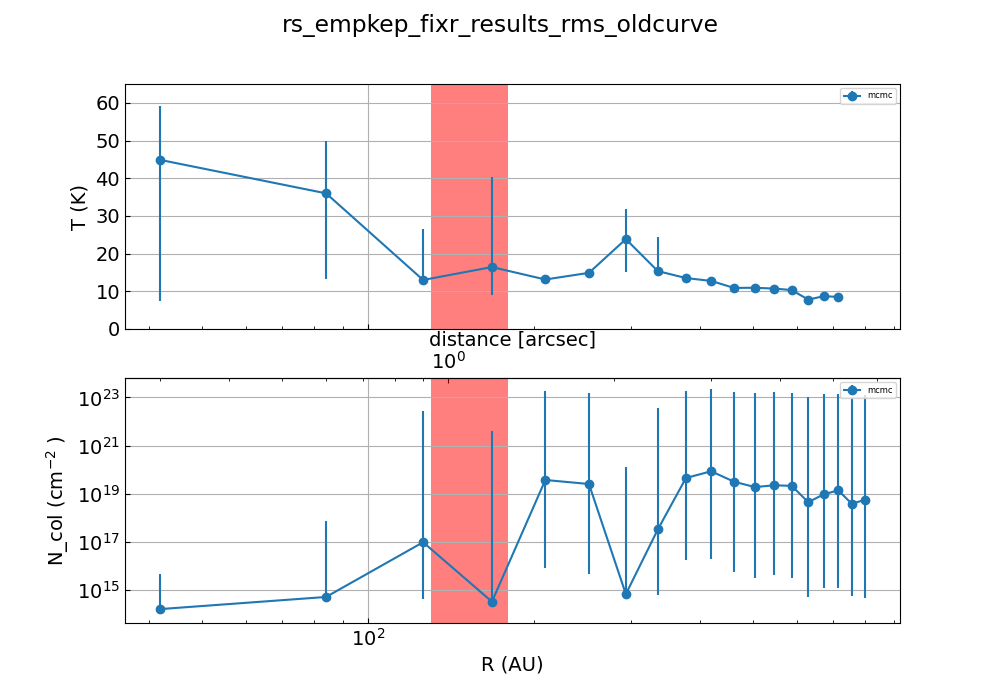

In [31]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 15.0]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: acceptable_r_range[0] <= triple[0] 
                                                                                    <= 5.1, 
                                                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                                                        np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,65)
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")


secax = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax.set_xlabel('distance [arcsec]')


vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')